## Uses all 4 classes/brands: POSTERIOR
## Transfer learning = resnet34

Example followed: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [62]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from statistics import mean 
from torchvision.utils import make_grid
import time
import sklearn.metrics
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
import seaborn as sn  # for heatmaps
import scipy.stats as st
  
plt.ion()   # interactive mode

In [63]:
# Reading train, test, val sets
train_set = pd.read_csv("/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/Train_full_data.csv")
train_set['brand']=train_set['Label']
train_set.loc[train_set['Label'] == 0.0, 'brand'] = 'mountaineer'
train_set.loc[train_set['Label'] == 1.0, 'brand'] = 'arch'
train_set.loc[train_set['Label'] == 2.0, 'brand'] = 'vertex'
train_set.loc[train_set['Label'] == 3.0, 'brand'] = 'virage_oasys_centerpiecevertex'

val_set = pd.read_csv("/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/Val_full_data.csv")
val_set['brand']=val_set['Label']
val_set.loc[val_set['Label'] == 0.0, 'brand'] = 'mountaineer'
val_set.loc[val_set['Label'] == 1.0, 'brand'] = 'arch'
val_set.loc[val_set['Label'] == 2.0, 'brand'] = 'vertex'
val_set.loc[val_set['Label'] == 3.0, 'brand'] = 'virage_oasys_centerpiecevertex'

test_set = pd.read_csv("/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/Test_full_data.csv")
test_set['brand']=test_set['Label']
test_set.loc[test_set['Label'] == 0.0, 'brand'] = 'mountaineer'
test_set.loc[test_set['Label'] == 1.0, 'brand'] = 'arch'
test_set.loc[test_set['Label'] == 2.0, 'brand'] = 'vertex'
test_set.loc[test_set['Label'] == 3.0, 'brand'] = 'virage_oasys_centerpiecevertex'

# Train
X_train = train_set['filepath']
Y_train = train_set['Label']
print("Training Set")
print(30*"-")
print(f'Records:\t{X_train.shape[0]}')
print("Brand Breakdown\n")
print(train_set['brand'].value_counts())

# Val
X_val = val_set['filepath']
Y_val = val_set['Label']
print("\nValidation Set")
print(30*"-")
print(f'Records:\t{X_val.shape[0]}')
print("Brand Breakdown\n")
print(val_set['brand'].value_counts())

# Test
X_test = test_set['filepath']
Y_test = test_set['Label']
print("\nTest Set\n")
print(30*"-")
print(f'Records:\t{X_test.shape[0]}')
print("Brand Breakdown")
print(test_set['brand'].value_counts())

Training Set
------------------------------
Records:	132
Brand Breakdown

mountaineer                       93
arch                              25
vertex                             8
virage_oasys_centerpiecevertex     6
Name: brand, dtype: int64

Validation Set
------------------------------
Records:	37
Brand Breakdown

mountaineer                       21
arch                              10
virage_oasys_centerpiecevertex     6
Name: brand, dtype: int64

Test Set

------------------------------
Records:	61
Brand Breakdown
mountaineer                       34
vertex                            15
virage_oasys_centerpiecevertex    10
arch                               2
Name: brand, dtype: int64


In [64]:
pwd

'/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior'

## Estimate mean and std of training data for normalization

In [65]:
# Just normalization for validation
aug_transform = {
    'train': transforms.Compose([
        #transforms.
        #transforms.RandomResizedCrop(224),
        transforms.Resize((256,256)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
    ]),

    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
    ])
}


data_dir = '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          aug_transform[x]) for x in ['train', 'val','test']}
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=True, num_workers =0)

pop_mean = []
pop_std0 = []

for i in range(len(train_loader.dataset.imgs)):
    inputs, classes = next(iter(train_loader))
    #display(plt.imshow(inputs[0][0]))
    batch_mean = inputs[0][0].mean().item()
    batch_std0 = inputs[0][0].std().item()
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    i += 1
    #print(mean)

def Average(lst): 

    return mean(lst) 
avg_pop_mean = Average(pop_mean)
avg_pop_std0 =Average(pop_std0)
print(Average(pop_mean))
print(Average(pop_std0))

print(f'Avg mean of training data: {avg_pop_mean}')
print(f'Avg std of training data: {avg_pop_std0}')

0.33615247645612917
0.2594108364234368
Avg mean of training data: 0.33615247645612917
Avg std of training data: 0.2594108364234368


## Load Data

In [66]:
# Augmentation pipeline
aug_transform = {
    'train': transforms.Compose([
        transforms.Resize((256,256)), # resize image to 256x256
        transforms.RandomHorizontalFlip(p=0.5), # horizontal flip
        transforms.RandomVerticalFlip(p=0.5), # vertical flip
        transforms.RandomRotation(degrees=(-15,15)),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0]) # normalize images
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)), # resize image to 256x256
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ]),

    'test': transforms.Compose([
        transforms.Resize((256, 256)), # resize image to 256x256
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ])
}

data_dir = '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          aug_transform[x]) for x in ['train', 'val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
class_names
image_datasets['test'].classes

['arch', 'mountaineer', 'vertex', 'virage_oasys_centrepiecevertex']

## View a batch of images

Label: [    0     3     2     1     1     1     1     1     2     1]
Class:  arch virage_oasys_centrepiecevertex vertex mountaineer mountaineer mountaineer mountaineer mountaineer vertex mountaineer


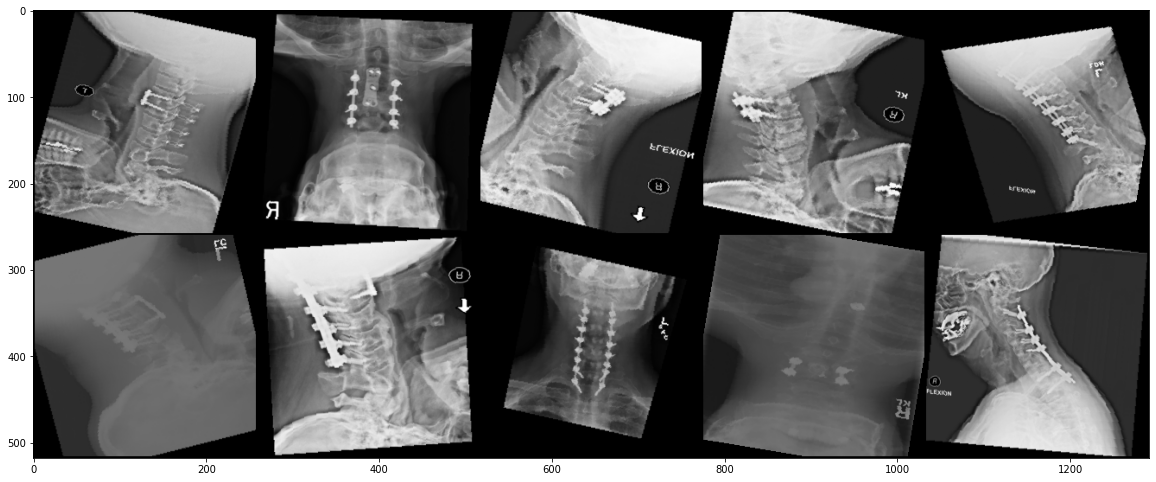

In [68]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in dataloaders['train']: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Model Training

In [69]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    
    for epoch in range(num_epochs):
        trn_corr = 0
        tst_corr = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_correct.append(epoch_acc.item())
            elif phase == 'val':
                val_losses.append(epoch_loss)
                val_correct.append(epoch_acc.item())
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_correct,val_correct

## Hyperparameter Tuning

In [10]:
lr1_list = [1e-7,1e-6]
lr2_list = [1e-1, 1e-2]
epochlist =[6, 10, 25]


# CREATING CRITEREON LIST
# Weightings for nlloss
value_counts_ = Y_train.value_counts().sort_index()
no_of_cats = len(value_counts_)
weightings = value_counts_.sum()/(value_counts_*no_of_cats).values
weightings = torch.FloatTensor(weightings) 
criterion_weighted = nn.NLLLoss(weight = weightings).to(device)
criterion_notweighted = nn.CrossEntropyLoss()

criterion_list = [criterion_weighted, criterion_notweighted]

# CREATING MODEL LIST
# Resnet34
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_34 = model_ft.to(device)

# Resnet34
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_50 = model_ft.to(device)

modellist = [model_34]

def metrics_function(y_predicted, y_probs, y_true):
    '''
    This function takes an input of predictions and true values and returns weighted precision, recall, f1 scores,
    and AUC scores. 
    Inputs:
        y_predicted: NumPy array of shape (n_samples,) which contains predictions of categories
        y_probs: NumPy array of shape (n_samples, n_classes) which contains probabilities for each class
        y_true: NumPy array of shape (n_samples,) which contains actual labels for samples
    Outputs:
        f1_score: Weighted F1-score
        precision: Weighted Precision score
        recall: Weighted recall score
        auc: Weighted AUC score calculated using One-Versus-Rest Approach
        confusion_matrix: Confusion Matrix
    '''
    import sklearn.metrics
    from sklearn.preprocessing import OneHotEncoder
    import numpy as np
    
    params = {
        'y_true': y_true,
        'y_pred': y_predicted,
        'average': 'weighted'
    }
    f1_score = sklearn.metrics.f1_score(**params)
    precision = sklearn.metrics.precision_score(**params)
    recall = sklearn.metrics.recall_score(**params)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true = y_true, y_pred = y_predicted)
    
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(np.array(y_true).reshape(-1,1))
    auc = sklearn.metrics.roc_auc_score(y_true = y_encoded.toarray(), y_score = y_probs, average='weighted', multi_class = 'ovr')
    
    return f1_score, precision, recall, auc, confusion_matrix

hypertuning = pd.DataFrame(columns =['lr1','lr2','epochs', 'criterion', 'model','balanced_accuracy_score'])

## TUNING 
# learning rate for model head
for lr1 in lr1_list:
    
    # learning rate for model tail
    for lr2 in lr2_list:
        
        # epochs
        for epochs in epochlist:
        
            # criterion
            for criterion in criterion_list:
            
                # model
                for model_ft in modellist:
                    
                    optimizer_ft = torch.optim.Adam([{'params': list(model_ft.parameters())[:-1], 'lr': lr1},{'params': list(model_ft.parameters())[-1], 'lr':lr2}])
                    
                    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)

                    model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,num_epochs=epochs)

                    # Calculate weighted f1
                    dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

                    y_test_list = []
                    pred_list = []
                    y_score_list = []
                    with torch.no_grad():
                        correct = 0
                        for X_test, y_test in dataloaders['val']:
                            X_test = X_test.to(device)
                            y_test = y_test.to(device)
                            y_val = model_ft(X_test)
                            y_val = y_val.to(device)
                            y_test_list.append(y_test.item())
                            y_score_list.append(y_val.to('cpu').numpy())
                            predicted = torch.max(y_val,1)[1]
                            pred_list.append(predicted.item())
                            correct += (predicted == y_test).sum()

                    y_test_list= np.asarray(y_test_list)
                    pred_list = np.asarray(pred_list)
                    y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
                    y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])
                    
                    acc = balanced_accuracy_score(y_test_list, pred_list)
    

                    # Saving hyperparameters and performance
                    rows = [[lr1,lr2, epochs, criterion, model_ft, acc]]
                    for row in rows:
                        hypertuning.loc[len(hypertuning)] = row

        
hypertuning.head()

Epoch 0/5
----------
train Loss: -1.1277 Acc: 0.5760
val Loss: -1.3724 Acc: 0.5217

Epoch 1/5
----------
train Loss: -3.3393 Acc: 0.7200
val Loss: -1.5910 Acc: 0.4348

Epoch 2/5
----------
train Loss: -5.7452 Acc: 0.7680
val Loss: -3.6479 Acc: 0.5435

Epoch 3/5
----------
train Loss: -8.6762 Acc: 0.8160
val Loss: -5.3701 Acc: 0.5000

Epoch 4/5
----------
train Loss: -10.9037 Acc: 0.7760
val Loss: -10.2938 Acc: 0.6304

Epoch 5/5
----------
train Loss: -13.6922 Acc: 0.8160
val Loss: -11.3349 Acc: 0.5870

Training complete in 1m 7s
Best val Acc: 0.630435


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Epoch 0/5
----------
train Loss: 0.5036 Acc: 0.9040
val Loss: 2.0123 Acc: 0.6739

Epoch 1/5
----------
train Loss: 0.5237 Acc: 0.8480
val Loss: 5.2445 Acc: 0.6304

Epoch 2/5
----------
train Loss: 0.4894 Acc: 0.8720
val Loss: 5.7115 Acc: 0.6304

Epoch 3/5
----------
train Loss: 0.3447 Acc: 0.8640
val Loss: 1.6945 Acc: 0.6087

Epoch 4/5
----------
train Loss: 0.2222 Acc: 0.9200
val Loss: 2.0577 Acc: 0.5435

Epoch 5/5
----------
train Loss: 0.2266 Acc: 0.9200
val Loss: 1.8463 Acc: 0.6087

Training complete in 1m 7s
Best val Acc: 0.673913
Epoch 0/9
----------
train Loss: -12.6453 Acc: 0.8960
val Loss: -11.7749 Acc: 0.6087

Epoch 1/9
----------
train Loss: -15.0866 Acc: 0.8720
val Loss: -8.2343 Acc: 0.6087

Epoch 2/9
----------
train Loss: -16.6761 Acc: 0.8720
val Loss: -10.5340 Acc: 0.6522

Epoch 3/9
----------
train Loss: -18.6665 Acc: 0.9280
val Loss: -12.8245 Acc: 0.6304

Epoch 4/9
----------
train Loss: -20.3981 Acc: 0.9120
val Loss: -14.9887 Acc: 0.6304

Epoch 5/9
----------
train Lo

train Loss: -29.1558 Acc: 0.9520
val Loss: -20.9573 Acc: 0.6087

Epoch 5/9
----------
train Loss: -33.2658 Acc: 0.9760
val Loss: -22.1720 Acc: 0.6087

Epoch 6/9
----------
train Loss: -36.3631 Acc: 0.9520
val Loss: -25.9261 Acc: 0.5652

Epoch 7/9
----------
train Loss: -38.8156 Acc: 0.9120
val Loss: -32.6416 Acc: 0.5870

Epoch 8/9
----------
train Loss: -42.2944 Acc: 0.8480
val Loss: -21.4595 Acc: 0.3478

Epoch 9/9
----------
train Loss: -47.9730 Acc: 0.8160
val Loss: -23.1620 Acc: 0.3261

Training complete in 1m 53s
Best val Acc: 0.652174
Epoch 0/9
----------
train Loss: 0.4254 Acc: 0.9360
val Loss: 7.4107 Acc: 0.5217

Epoch 1/9
----------
train Loss: 0.6083 Acc: 0.9440
val Loss: 7.9826 Acc: 0.5870

Epoch 2/9
----------
train Loss: 0.2767 Acc: 0.9280
val Loss: 7.6114 Acc: 0.6522

Epoch 3/9
----------
train Loss: 0.5769 Acc: 0.9200
val Loss: 7.7063 Acc: 0.6087

Epoch 4/9
----------
train Loss: 0.2094 Acc: 0.9760
val Loss: 6.6258 Acc: 0.5652

Epoch 5/9
----------
train Loss: 0.1608 Acc:

train Loss: 0.1144 Acc: 0.9600
val Loss: 9.5792 Acc: 0.4783

Epoch 5/9
----------
train Loss: 0.0684 Acc: 0.9840
val Loss: 7.3595 Acc: 0.6087

Epoch 6/9
----------
train Loss: 0.1377 Acc: 0.9920
val Loss: 6.2188 Acc: 0.5217

Epoch 7/9
----------
train Loss: 0.4374 Acc: 0.9600
val Loss: 5.5253 Acc: 0.5652

Epoch 8/9
----------
train Loss: 0.1149 Acc: 0.9680
val Loss: 10.4360 Acc: 0.5652

Epoch 9/9
----------
train Loss: 0.2305 Acc: 0.9200
val Loss: 6.3935 Acc: 0.6522

Training complete in 1m 53s
Best val Acc: 0.652174
Epoch 0/24
----------
train Loss: -31.2304 Acc: 0.9360
val Loss: -23.7828 Acc: 0.5652

Epoch 1/24
----------
train Loss: -34.8597 Acc: 0.9760
val Loss: -19.3907 Acc: 0.5652

Epoch 2/24
----------
train Loss: -36.0924 Acc: 0.9840
val Loss: -27.2710 Acc: 0.6522

Epoch 3/24
----------
train Loss: -38.5513 Acc: 0.9280
val Loss: -26.1101 Acc: 0.6087

Epoch 4/24
----------
train Loss: -41.2091 Acc: 0.9680
val Loss: -31.1270 Acc: 0.6304

Epoch 5/24
----------
train Loss: -42.2956

train Loss: -70.9633 Acc: 0.9520
val Loss: -48.5960 Acc: 0.5435

Epoch 5/24
----------
train Loss: -74.9272 Acc: 0.9280
val Loss: -41.9475 Acc: 0.2609

Epoch 6/24
----------
train Loss: -78.2630 Acc: 0.8640
val Loss: -49.1563 Acc: 0.3913

Epoch 7/24
----------
train Loss: -80.5455 Acc: 0.8560
val Loss: -70.5715 Acc: 0.6522

Epoch 8/24
----------
train Loss: -87.6763 Acc: 0.9120
val Loss: -84.1042 Acc: 0.5870

Epoch 9/24
----------
train Loss: -89.8629 Acc: 0.8160
val Loss: -80.9495 Acc: 0.6304

Epoch 10/24
----------
train Loss: -99.1477 Acc: 0.8720
val Loss: -75.2195 Acc: 0.1522

Epoch 11/24
----------
train Loss: -97.7163 Acc: 0.7680
val Loss: -84.8528 Acc: 0.5652

Epoch 12/24
----------
train Loss: -111.2752 Acc: 0.7680
val Loss: -142.0601 Acc: 0.5870

Epoch 13/24
----------
train Loss: -125.1333 Acc: 0.7360
val Loss: -22.1760 Acc: 0.1522

Epoch 14/24
----------
train Loss: -139.9969 Acc: 0.6640
val Loss: -140.1231 Acc: 0.5652

Epoch 15/24
----------
train Loss: -156.1271 Acc: 0.736

,lr1,lr2,epochs,criterion,model,balanced_accuracy_score
0,1.000000e-07,0.1,6,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.333333
1,1.000000e-07,0.1,6,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.522222
2,1.000000e-07,0.1,10,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.500000
3,1.000000e-07,0.1,10,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.655172
4,1.000000e-07,0.1,25,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.333333


In [11]:
hypertuning

,lr1,lr2,epochs,criterion,model,balanced_accuracy_score
0,1.000000e-07,0.10,6,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.333333
1,1.000000e-07,0.10,6,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.522222
2,1.000000e-07,0.10,10,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.500000
3,1.000000e-07,0.10,10,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.655172
4,1.000000e-07,0.10,25,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.333333
5,1.000000e-07,0.10,25,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.666667
6,1.000000e-07,0.01,6,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.500000
7,1.000000e-07,0.01,6,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.500000
8,1.000000e-07,0.01,10,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.500000
9,1.000000e-07,0.01,10,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.500000


In [14]:
hypertuning[hypertuning['balanced_accuracy_score']==hypertuning['balanced_accuracy_score'].max()]

,lr1,lr2,epochs,criterion,model,balanced_accuracy_score
5,1.000000e-07,0.10,25,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.666667
23,1.000000e-06,0.01,25,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.666667


## Finetuning the convnet

### TEST 1

In [23]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam([
    {'params': list(model_ft.parameters())[:-1], 'lr': 1e-7},#, 'momentum': 0.9, 'weight_decay': 1e-4},
    {'params': list(model_ft.parameters())[-1], 'lr':  1e-1}#, 'momentum': 0.9, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)

In [24]:
# Total model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    #for item in params:
        #print(f'{item:>6}')
    print(f'Total model parameters: {sum(params):>6}')
    
count_parameters(model_ft)

Total model parameters: 21286724


## Train model

In [25]:
epochs=25
model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=epochs)

Epoch 0/24
----------
train Loss: 1.3924 Acc: 0.4015
val Loss: 1.1904 Acc: 0.5946

Epoch 1/24
----------
train Loss: 0.4069 Acc: 0.9015
val Loss: 0.9444 Acc: 0.6757

Epoch 2/24
----------
train Loss: 0.3591 Acc: 0.8864
val Loss: 0.6884 Acc: 0.7297

Epoch 3/24
----------
train Loss: 0.2795 Acc: 0.9318
val Loss: 0.5419 Acc: 0.8108

Epoch 4/24
----------
train Loss: 0.1495 Acc: 0.9470
val Loss: 0.4955 Acc: 0.8108

Epoch 5/24
----------
train Loss: 0.1155 Acc: 0.9621
val Loss: 0.4551 Acc: 0.8378

Epoch 6/24
----------
train Loss: 0.3102 Acc: 0.8864
val Loss: 3.4876 Acc: 0.2703

Epoch 7/24
----------
train Loss: 0.1884 Acc: 0.9318
val Loss: 1.7546 Acc: 0.6216

Epoch 8/24
----------
train Loss: 0.2008 Acc: 0.9394
val Loss: 1.3615 Acc: 0.7297

Epoch 9/24
----------
train Loss: 0.3437 Acc: 0.8939
val Loss: 1.2207 Acc: 0.6216

Epoch 10/24
----------
train Loss: 0.2219 Acc: 0.9091
val Loss: 1.7139 Acc: 0.7027

Epoch 11/24
----------
train Loss: 0.2793 Acc: 0.8939
val Loss: 2.4009 Acc: 0.4324

Ep

## Save the model

In [26]:
torch.save(model_ft.state_dict(), '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/Resnet34__posterior_ep25_CEloss_run1.pt')

## Plot the loss and accuracy comparisons

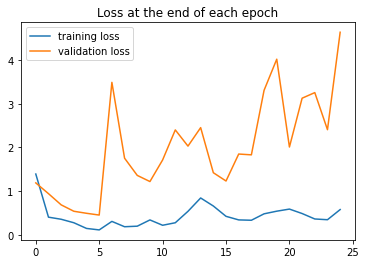

In [27]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

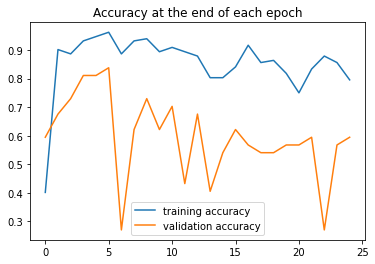

In [28]:
plt.plot(range(epochs),train_correct, label='training accuracy')
plt.plot(range(epochs), val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Load model

# Instantiate the model and load saved parameters
model2 = models.resnet34(pretrained=True)
num_ftrs = model2.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model2.fc = nn.Linear(num_ftrs, len(class_names))

model2 = model2.to(device)
model2.load_state_dict(torch.load('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/Resnet34_alldata_posterior_ep10_nlloss.pt'))
model2.eval()

## Display Metrics and Confusion matrix

In [29]:
def metrics_function(y_predicted, y_probs, y_true):
    '''
    This function takes an input of predictions and true values and returns weighted precision, recall, f1 scores,
    and AUC scores. 
    Inputs:
        y_predicted: NumPy array of shape (n_samples,) which contains predictions of categories
        y_probs: NumPy array of shape (n_samples, n_classes) which contains probabilities for each class
        y_true: NumPy array of shape (n_samples,) which contains actual labels for samples
    Outputs:
        f1_score: Weighted F1-score
        precision: Weighted Precision score
        recall: Weighted recall score
        auc: Weighted AUC score calculated using One-Versus-Rest Approach
        confusion_matrix: Confusion Matrix
    '''
    import sklearn.metrics
    from sklearn.preprocessing import OneHotEncoder
    import numpy as np
    
    params = {
        'y_true': y_true,
        'y_pred': y_predicted,
        'average': 'weighted'
    }
    f1_score = sklearn.metrics.f1_score(**params)
    precision = sklearn.metrics.precision_score(**params)
    recall = sklearn.metrics.recall_score(**params)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true = y_true, y_pred = y_predicted)
    
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(np.array(y_true).reshape(-1,1))
    auc = sklearn.metrics.roc_auc_score(y_true = y_encoded.toarray(), y_score = y_probs, average='weighted', multi_class = 'ovr')
    
    return f1_score, precision, recall, auc, confusion_matrix

In [34]:
# Track metrics
metrics_pd =pd.DataFrame(columns =['train_f1','train_precision','train_recall', 'train_auc', 
                                  'test_f1','test_precision', 'test_recall', 'test_auc'])

### Training Set

TRAINING SET METRICS
------------------------------------------------------------
Test accuracy:		0.9772727272727273
Balanced accuracy:	0.9529569892473119
Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.99      0.98      0.98        93
           2       0.80      1.00      0.89         8
           3       1.00      0.83      0.91         6

    accuracy                           0.98       132
   macro avg       0.95      0.95      0.95       132
weighted avg       0.98      0.98      0.98       132



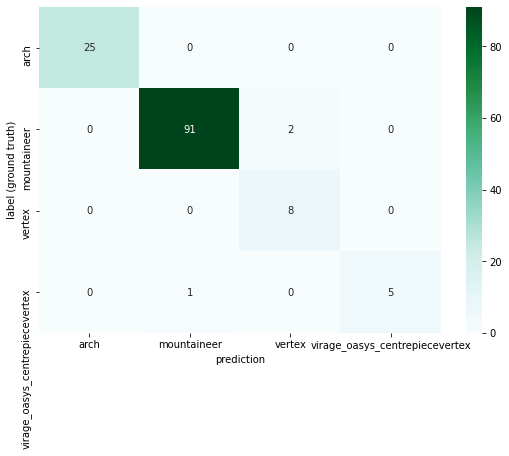

***TRAINING SET***
F1 score is 0.9777087004359731
Precision score is 0.9802206851119895
recall score is 0.9772727272727273
auc score is 0.9988344988344988
confusion_matrix score is:
[[   25     0     0     0]
 [    0    91     2     0]
 [    0     0     8     0]
 [    0     1     0     5]]


In [35]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False)
y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['train']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('TRAINING SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


train_f1_score, train_precision, train_recall, train_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TRAINING SET***")
print(f'F1 score is {train_f1_score}')
print(f'Precision score is {train_precision}')
print(f'recall score is {train_recall}')
print(f'auc score is {train_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

### Validation Set

VALIDATION SET METRICS
------------------------------------------------------------
Test accuracy:		0.8378378378378378
Balanced accuracy:	0.6888888888888888
Classification report:

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      1.00      0.93        21
           2       0.00      0.00      0.00         0
           3       1.00      0.17      0.29         6

    accuracy                           0.84        37
   macro avg       0.67      0.52      0.52        37
weighted avg       0.88      0.84      0.81        37



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


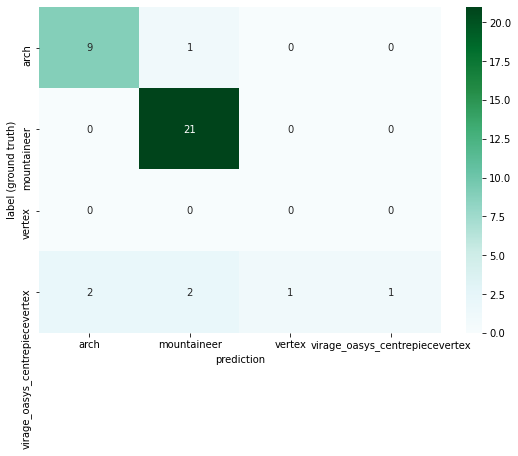

In [41]:
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['val']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('VALIDATION SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

#val_f1_score, val_precision, val_recall, val_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
#print("***VALIDATION SET***")
#print(f'F1 score is {val_f1_score}')
#print(f'Precision score is {val_precision}')
#print(f'recall score is {val_recall}')
#print(f'auc score is {val_auc}')
#print(f'confusion_matrix score is:')
#print(confusion_matrix)

### Test Set

TEST SET METRICS
------------------------------------------------------------
Test accuracy:		0.5573770491803278
Balanced accuracy:	0.42058823529411765
Classification report:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.58      0.88      0.70        34
           2       0.00      0.00      0.00        15
           3       0.43      0.30      0.35        10

    accuracy                           0.56        61
   macro avg       0.50      0.42      0.43        61
weighted avg       0.42      0.56      0.47        61



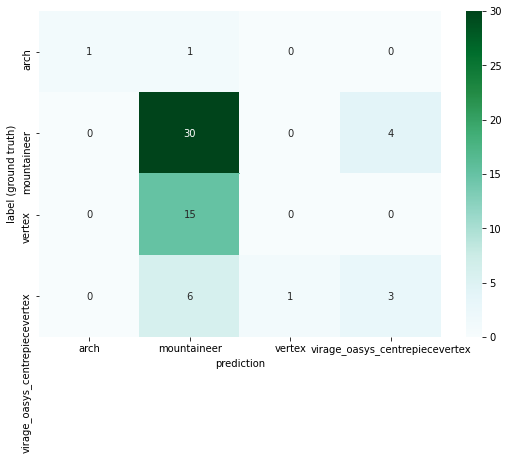

***TEST SET***
F1 score is 0.46858484148520246
Precision score is 0.42460817870653933
recall score is 0.5573770491803278
auc score is 0.516569691153566
confusion_matrix score is:
[[    1     1     0     0]
 [    0    30     0     4]
 [    0    15     0     0]
 [    0     6     1     3]]


In [33]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
test_set = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['test']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        test_set.append(X_test)
        correct += (predicted == y_test).sum()
 
print('TEST SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))
#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


test_f1_score, test_precision, test_recall, test_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TEST SET***")
print(f'F1 score is {test_f1_score}')
print(f'Precision score is {test_precision}')
print(f'recall score is {test_recall}')
print(f'auc score is {test_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

In [36]:
rows = [[train_f1_score,train_precision, train_recall, train_auc, 
        test_f1_score, test_precision, test_recall, test_auc]]
for row in rows:
    metrics_pd.loc[len(metrics_pd)] = row

In [37]:
metrics_pd

,train_f1,train_precision,train_recall,train_auc,test_f1,test_precision,test_recall,test_auc
0,0.977709,0.980221,0.977273,0.998834,0.468585,0.424608,0.557377,0.51657


### RUN 2

In [50]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam([
    {'params': list(model_ft.parameters())[:-1], 'lr': 1e-7},#, 'momentum': 0.9, 'weight_decay': 1e-4},
    {'params': list(model_ft.parameters())[-1], 'lr':  1e-1}#, 'momentum': 0.9, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)

In [51]:
# Total model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    #for item in params:
        #print(f'{item:>6}')
    print(f'Total model parameters: {sum(params):>6}')
    
count_parameters(model_ft)

Total model parameters: 21286724


In [52]:
epochs=25
model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=epochs)

Epoch 0/24
----------
train Loss: 1.0893 Acc: 0.5530
val Loss: 1.2878 Acc: 0.5405

Epoch 1/24
----------
train Loss: 0.4314 Acc: 0.8636
val Loss: 0.8879 Acc: 0.6486

Epoch 2/24
----------
train Loss: 0.2276 Acc: 0.9242
val Loss: 0.8685 Acc: 0.7568

Epoch 3/24
----------
train Loss: 0.1866 Acc: 0.9318
val Loss: 0.8481 Acc: 0.7027

Epoch 4/24
----------
train Loss: 0.2325 Acc: 0.9167
val Loss: 0.6762 Acc: 0.7568

Epoch 5/24
----------
train Loss: 0.2422 Acc: 0.9242
val Loss: 1.1457 Acc: 0.8108

Epoch 6/24
----------
train Loss: 0.2846 Acc: 0.9167
val Loss: 1.1884 Acc: 0.7297

Epoch 7/24
----------
train Loss: 0.2484 Acc: 0.9318
val Loss: 2.6438 Acc: 0.4054

Epoch 8/24
----------
train Loss: 0.3121 Acc: 0.9318
val Loss: 1.1787 Acc: 0.7838

Epoch 9/24
----------
train Loss: 0.2533 Acc: 0.8788
val Loss: 1.9741 Acc: 0.7838

Epoch 10/24
----------
train Loss: 0.2313 Acc: 0.8636
val Loss: 2.8489 Acc: 0.5676

Epoch 11/24
----------
train Loss: 0.3655 Acc: 0.8788
val Loss: 3.2345 Acc: 0.5676

Ep

In [53]:
torch.save(model_ft.state_dict(), '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/Resnet34__posterior_ep25_CEloss_run2.pt')

### Plot the loss and accuracy comparisons

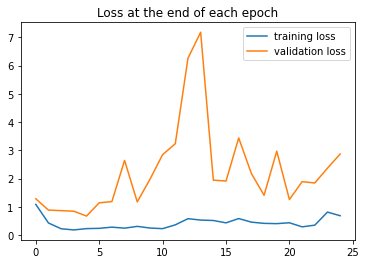

In [54]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

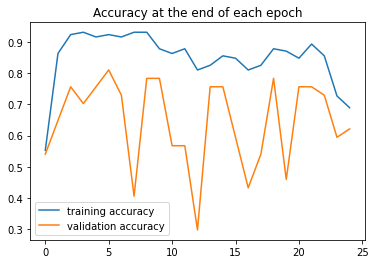

In [55]:
plt.plot(range(epochs),train_correct, label='training accuracy')
plt.plot(range(epochs), val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Training Set

TRAINING SET METRICS
------------------------------------------------------------
Test accuracy:		0.946969696969697
Balanced accuracy:	0.8746639784946236
Classification report:

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        25
           1       1.00      0.96      0.98        93
           2       0.70      0.88      0.78         8
           3       1.00      0.67      0.80         6

    accuracy                           0.95       132
   macro avg       0.89      0.87      0.87       132
weighted avg       0.96      0.95      0.95       132



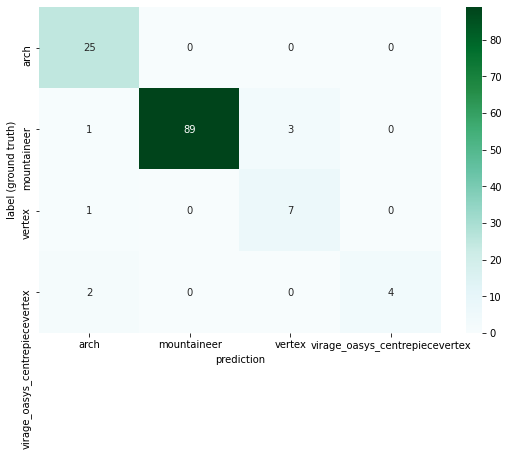

***TRAINING SET***
F1 score is 0.9479273812607145
Precision score is 0.9556948798328108
recall score is 0.946969696969697
auc score is 0.9901114368441771
confusion_matrix score is:
[[   25     0     0     0]
 [    1    89     3     0]
 [    1     0     7     0]
 [    2     0     0     4]]


In [56]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False)
y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['train']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('TRAINING SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


train_f1_score, train_precision, train_recall, train_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TRAINING SET***")
print(f'F1 score is {train_f1_score}')
print(f'Precision score is {train_precision}')
print(f'recall score is {train_recall}')
print(f'auc score is {train_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

### Validation Set

VALIDATION SET METRICS
------------------------------------------------------------
Test accuracy:		0.8108108108108109
Balanced accuracy:	0.6507936507936508
Classification report:

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.91      0.95      0.93        21
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         6

    accuracy                           0.81        37
   macro avg       0.41      0.49      0.44        37
weighted avg       0.71      0.81      0.75        37



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


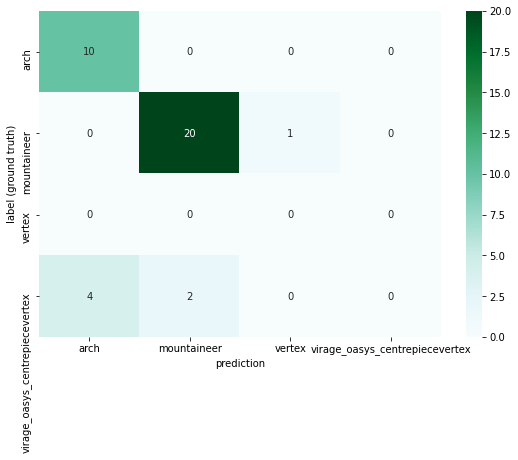

In [57]:
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['val']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('VALIDATION SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

#val_f1_score, val_precision, val_recall, val_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
#print("***VALIDATION SET***")
#print(f'F1 score is {val_f1_score}')
#print(f'Precision score is {val_precision}')
#print(f'recall score is {val_recall}')
#print(f'auc score is {val_auc}')
#print(f'confusion_matrix score is:')
#print(confusion_matrix)

### Test Set

TEST SET METRICS
------------------------------------------------------------
Test accuracy:		0.47540983606557374
Balanced accuracy:	0.2838235294117647
Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.57      0.74      0.64        34
           2       0.00      0.00      0.00        15
           3       0.31      0.40      0.35        10

    accuracy                           0.48        61
   macro avg       0.22      0.28      0.25        61
weighted avg       0.37      0.48      0.41        61



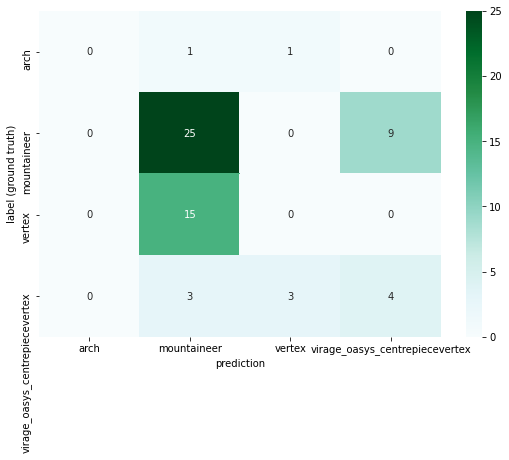

***TEST SET***
F1 score is 0.4143136502366723
Precision score is 0.36713286713286714
recall score is 0.47540983606557374
auc score is 0.4630658327280507
confusion_matrix score is:
[[    0     1     1     0]
 [    0    25     0     9]
 [    0    15     0     0]
 [    0     3     3     4]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
test_set = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['test']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        test_set.append(X_test)
        correct += (predicted == y_test).sum()
 
print('TEST SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))
#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


test_f1_score, test_precision, test_recall, test_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TEST SET***")
print(f'F1 score is {test_f1_score}')
print(f'Precision score is {test_precision}')
print(f'recall score is {test_recall}')
print(f'auc score is {test_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

In [59]:
rows = [[train_f1_score,train_precision, train_recall, train_auc, 
        test_f1_score, test_precision, test_recall, test_auc]]
for row in rows:
    metrics_pd.loc[len(metrics_pd)] = row

metrics_pd

,train_f1,train_precision,train_recall,train_auc,test_f1,test_precision,test_recall,test_auc
0,0.977709,0.980221,0.977273,0.998834,0.468585,0.424608,0.557377,0.516570
1,0.947927,0.955695,0.946970,0.990111,0.414314,0.367133,0.475410,0.463066


### RUN 3

In [70]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam([
    {'params': list(model_ft.parameters())[:-1], 'lr': 1e-7},#, 'momentum': 0.9, 'weight_decay': 1e-4},
    {'params': list(model_ft.parameters())[-1], 'lr':  1e-1}#, 'momentum': 0.9, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)

In [71]:
# Total model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    #for item in params:
        #print(f'{item:>6}')
    print(f'Total model parameters: {sum(params):>6}')
    
count_parameters(model_ft)

Total model parameters: 21286724


In [72]:
epochs=25
model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=epochs)

Epoch 0/24
----------
train Loss: 0.9917 Acc: 0.5833
val Loss: 1.0529 Acc: 0.7027

Epoch 1/24
----------
train Loss: 0.4427 Acc: 0.8864
val Loss: 1.1424 Acc: 0.6486

Epoch 2/24
----------
train Loss: 0.2967 Acc: 0.9015
val Loss: 0.9576 Acc: 0.7568

Epoch 3/24
----------
train Loss: 0.2597 Acc: 0.9091
val Loss: 0.6938 Acc: 0.8108

Epoch 4/24
----------
train Loss: 0.2376 Acc: 0.9470
val Loss: 0.8435 Acc: 0.6757

Epoch 5/24
----------
train Loss: 0.2200 Acc: 0.9167
val Loss: 0.8396 Acc: 0.7027

Epoch 6/24
----------
train Loss: 0.2415 Acc: 0.9167
val Loss: 2.0462 Acc: 0.5405

Epoch 7/24
----------
train Loss: 0.2002 Acc: 0.9091
val Loss: 0.8473 Acc: 0.7838

Epoch 8/24
----------
train Loss: 0.2057 Acc: 0.9167
val Loss: 1.1892 Acc: 0.8108

Epoch 9/24
----------
train Loss: 0.5443 Acc: 0.8561
val Loss: 2.2207 Acc: 0.7027

Epoch 10/24
----------
train Loss: 0.4309 Acc: 0.8788
val Loss: 1.7420 Acc: 0.7297

Epoch 11/24
----------
train Loss: 0.4263 Acc: 0.8485
val Loss: 1.0874 Acc: 0.6757

Ep

In [73]:
torch.save(model_ft.state_dict(), '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/posterior/Resnet34__posterior_ep25_CEloss_run3.pt')

### Plot the loss and accuracy comparisons

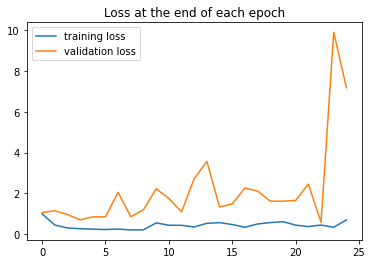

In [74]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

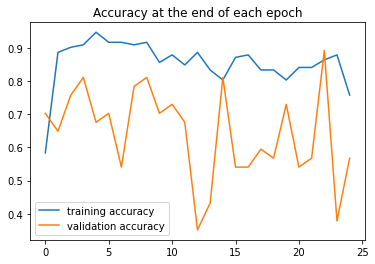

In [75]:
plt.plot(range(epochs),train_correct, label='training accuracy')
plt.plot(range(epochs), val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Training Set

TRAINING SET METRICS
------------------------------------------------------------
Test accuracy:		0.8484848484848485
Balanced accuracy:	0.6895967741935484
Classification report:

              precision    recall  f1-score   support

           0       0.73      0.96      0.83        25
           1       0.94      0.88      0.91        93
           2       0.33      0.25      0.29         8
           3       0.67      0.67      0.67         6

    accuracy                           0.85       132
   macro avg       0.67      0.69      0.67       132
weighted avg       0.85      0.85      0.85       132



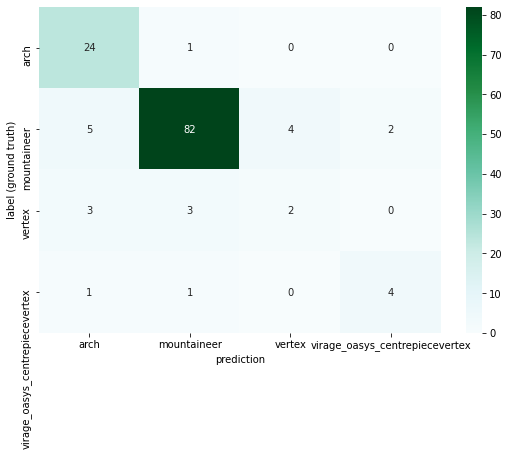

***TRAINING SET***
F1 score is 0.8462780514504653
Precision score is 0.852300433805136
recall score is 0.8484848484848485
auc score is 0.9476389973262147
confusion_matrix score is:
[[   24     1     0     0]
 [    5    82     4     2]
 [    3     3     2     0]
 [    1     1     0     4]]


In [76]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False)
y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['train']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('TRAINING SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


train_f1_score, train_precision, train_recall, train_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TRAINING SET***")
print(f'F1 score is {train_f1_score}')
print(f'Precision score is {train_precision}')
print(f'recall score is {train_recall}')
print(f'auc score is {train_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

### Validation Set

In [80]:
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['val']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('VALIDATION SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
#arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
#df_cm = pd.DataFrame(arr, class_names, class_names)
#plt.figure(figsize = (9,6))
#sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
#plt.xlabel("prediction")
#plt.ylabel("label (ground truth)")
#plt.show();

#y_test_list= np.asarray(y_test_list)
#pred_list = np.asarray(pred_list)
#y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
#y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

#val_f1_score, val_precision, val_recall, val_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
#print("***VALIDATION SET***")
#print(f'F1 score is {val_f1_score}')
#print(f'Precision score is {val_precision}')
#print(f'recall score is {val_recall}')
#print(f'auc score is {val_auc}')
#print(f'confusion_matrix score is:')
#print(confusion_matrix)

VALIDATION SET METRICS
------------------------------------------------------------
Test accuracy:		0.8918918918918919
Balanced accuracy:	0.7777777777777778
Classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.91      1.00      0.95        21
           3       1.00      0.33      0.50         6

    accuracy                           0.89        37
   macro avg       0.92      0.78      0.79        37
weighted avg       0.91      0.89      0.87        37



### Test Set

TEST SET METRICS
------------------------------------------------------------
Test accuracy:		0.5081967213114754
Balanced accuracy:	0.49019607843137253
Classification report:

              precision    recall  f1-score   support

           0       0.18      1.00      0.31         2
           1       0.59      0.79      0.68        34
           2       1.00      0.07      0.12        15
           3       0.33      0.10      0.15        10

    accuracy                           0.51        61
   macro avg       0.53      0.49      0.32        61
weighted avg       0.63      0.51      0.44        61



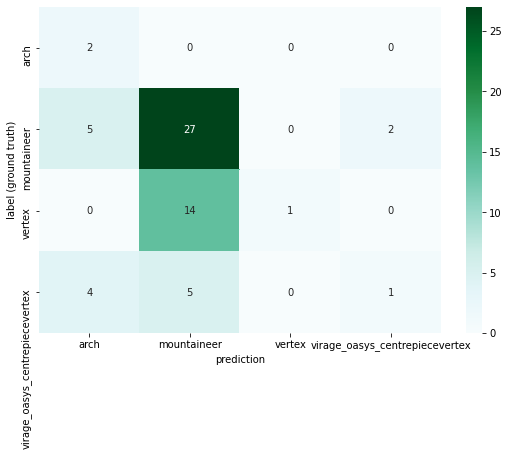

***TEST SET***
F1 score is 0.44227616645649437
Precision score is 0.6336637940344284
recall score is 0.5081967213114754
auc score is 0.5301509215391234
confusion_matrix score is:
[[    2     0     0     0]
 [    5    27     0     2]
 [    0    14     1     0]
 [    4     5     0     1]]


In [78]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
test_set = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['test']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        test_set.append(X_test)
        correct += (predicted == y_test).sum()
 
print('TEST SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))
#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


test_f1_score, test_precision, test_recall, test_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TEST SET***")
print(f'F1 score is {test_f1_score}')
print(f'Precision score is {test_precision}')
print(f'recall score is {test_recall}')
print(f'auc score is {test_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

In [79]:
rows = [[train_f1_score,train_precision, train_recall, train_auc, 
        test_f1_score, test_precision, test_recall, test_auc]]
for row in rows:
    metrics_pd.loc[len(metrics_pd)] = row

metrics_pd

,train_f1,train_precision,train_recall,train_auc,test_f1,test_precision,test_recall,test_auc
0,0.977709,0.980221,0.977273,0.998834,0.468585,0.424608,0.557377,0.516570
1,0.947927,0.955695,0.946970,0.990111,0.414314,0.367133,0.475410,0.463066
2,0.846278,0.852300,0.848485,0.947639,0.442276,0.633664,0.508197,0.530151


### Calculating Final Metrics

In [81]:
metrics_pd.to_csv('posterior_metrics.csv', header=True)

In [82]:
compiled = metrics_pd[['test_f1', 'test_precision', 'test_recall', 'test_auc']]
compiled

,test_f1,test_precision,test_recall,test_auc
0,0.468585,0.424608,0.557377,0.516570
1,0.414314,0.367133,0.475410,0.463066
2,0.442276,0.633664,0.508197,0.530151


In [83]:
# Calculating compiled results
conf_int = compiled.apply(lambda x: st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x)))
means = compiled.apply(lambda x: np.mean(x))
support = compiled.apply(lambda x: len(x))
# Putting them together
final = pd.concat([means,conf_int, support], axis = 1)
final.columns = ["Mean", "Confidence Intervals", "Support"]
final

,Mean,Confidence Intervals,Support
test_f1,0.441725,"(0.37430589735980335, 0.5091438747591095)",3
test_precision,0.475135,"(0.12669622611425674, 0.8235736671349665)",3
test_recall,0.513661,"(0.41117580088069594, 0.6161466034908888)",3
test_auc,0.503262,"(0.41515680846272607, 0.5913674884844339)",3
